In [1]:
# %matplotlib inline
import pyccl as ccl
import numpy as np
import pylab as plt
import glass.observations
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.lines import Line2D

In [20]:
cosmo = ccl.Cosmology(
    Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96,
    transfer_function='boltzmann_camb', m_nu=0.0, mass_split='equal')

cosmo_zero_single = ccl.Cosmology(
    Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96,
    transfer_function='boltzmann_camb', m_nu=0.0, mass_split='single') # mass_split='single'; the sum of neutrino masses is carried by one massive neutrino

cosmo_neutrino = ccl.Cosmology(
    Omega_c=0.27-0.0017942, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96,
    m_nu=0.075, mass_split='equal',
    transfer_function='boltzmann_camb')

cosmo_single = ccl.Cosmology(
    Omega_c=0.27-0.001793799,
    Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96,
    m_nu=0.075, mass_split='single',
    transfer_function='boltzmann_camb')

In [3]:
# Redshift-dependent functions
z = np.linspace(0,3.0,3024)

# Bias
bz = 0.95/ccl.growth_factor(cosmo,1./(1+z))

bz_zero_single = 0.95/ccl.growth_factor(cosmo_zero_single,1./(1+z))

# Bias
bz_nu = 0.95/ccl.growth_factor(cosmo_neutrino,1./(1+z))

# Bias
bz_nu_single= 0.95/ccl.growth_factor(cosmo_single,1./(1+z))

In [4]:
print("matter:", 
      ccl.omega_x(cosmo, 1., "matter"), 
      ccl.omega_x(cosmo_neutrino, 1., "matter"), 
      ccl.omega_x(cosmo_single, 1., "matter"), 
      ccl.omega_x(cosmo_zero_single, 1., "matter"))

print("dark energy:",
      ccl.omega_x(cosmo, 1., "dark_energy"),
      ccl.omega_x(cosmo_neutrino, 1., "dark_energy"),
      ccl.omega_x(cosmo_single, 1., "dark_energy"))

print("Masive Neutrinos:",
      ccl.omega_x(cosmo, 1., "neutrinos_massive"),
      ccl.omega_x(cosmo_neutrino, 1., "neutrinos_massive"),
      ccl.omega_x(cosmo_single, 1., "neutrinos_massive"),
      ccl.omega_x(cosmo_zero_single, 1., "neutrinos_massive"))

print("curvature:",
      ccl.omega_x(cosmo, 1., "curvature"),
      ccl.omega_x(cosmo_neutrino, 1., "curvature"),
      ccl.omega_x(cosmo_single, 1., "curvature"))

matter: 0.315 0.31500006558600224 0.31500000004392265 0.315
dark energy: 0.6849068260310955 0.6849447897545639 0.6849195024236633
Masive Neutrinos: 0.0 0.0017942655860022606 0.0017937990439225399 0.0
curvature: 0.0 0.0 0.0


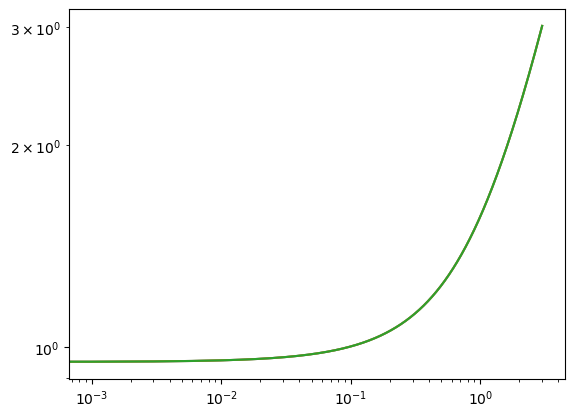

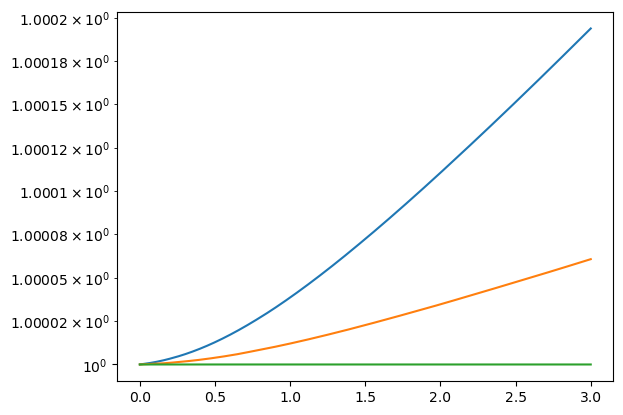

In [5]:
plt.loglog()
plt.plot(z, bz)
plt.plot(z, bz_nu)
plt.plot(z, bz_nu_single)

plt.figure()
plt.yscale('log')
plt.plot(z, bz_nu/bz)
plt.plot(z, bz_nu_single/bz)
plt.plot(z, bz_zero_single/bz)


In [6]:
# galaxy density (using 1/100 of the expected galaxy number density for Stage-IV)
n_arcmin2 = 0.3

# true redshift distribution following a Smail distribution
dndz = glass.observations.smail_nz(z, z_mode=0.9, alpha=2., beta=1.5)
dndz *= n_arcmin2

# compute tomographic redshift bin edges with equal density
nbins = 10
zbins = glass.observations.equal_dens_zbins(z, dndz, nbins=nbins)

# photometric redshift error
sigma_z0 = 0.03

# split dndz using the same Gaussian error model assumed in the sampling
tomo_nz = glass.observations.tomo_nz_gausserr(z, dndz, sigma_z0, zbins)


In [7]:
# a heaviside function from 0.9 to 1.8 convolved with the true redshift distribution
spec_z = (np.heaviside(z-0.9, 1) - np.heaviside(z-1.8, 1))*dndz

In [8]:
zbins_spec = glass.observations.fixed_zbins(zmin=0.9, zmax=1.8, dz=0.05)
# split dndz using the same Gaussian error model assumed in the sampling
tomo_nz_spec = glass.observations.tomo_nz_gausserr(z, spec_z, 0.0003, zbins_spec)

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2175/1115222304.py:1: SyntaxWarning: invalid escape sequence '\D'
  plt.title('Euclid Spectroscopic Sample in Tomographic Bins of $\Delta z = 0.05$')


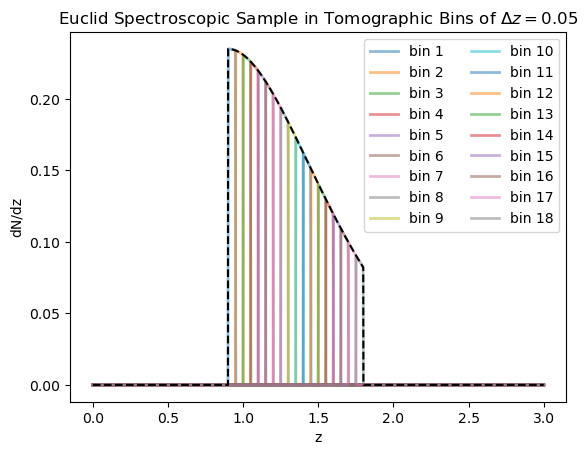

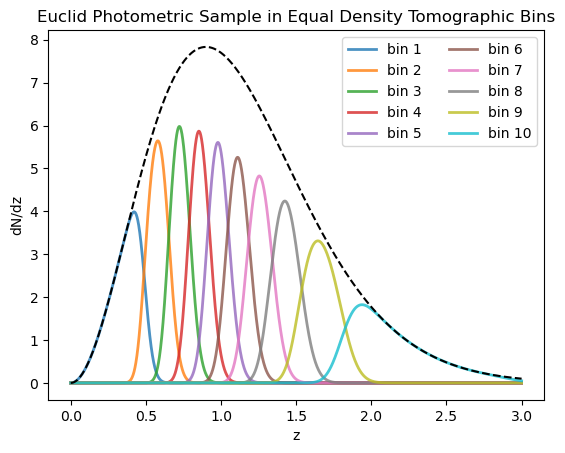

In [ ]:
plt.title('Euclid Spectroscopic Sample in Tomographic Bins of $\Delta z = 0.05$')
for i in range(len(tomo_nz_spec)):
    plt.plot(z, tomo_nz_spec[i], alpha=0.5, label=f'bin {i+1}', lw=2)
plt.plot(z, spec_z, ls='--', c='k')
plt.legend(loc=0, ncol=2)
plt.ylabel('dN/dz')
plt.xlabel('z')
#plt.savefig('euclid_spec_tomo_bins.png', dpi=300)
plt.show()

plt.title('Euclid Photometric Sample in Equal Density Tomographic Bins')
for i in range(nbins):
    plt.plot(z, (tomo_nz[i]/n_arcmin2)*nbins, alpha=0.8, lw=2,label=f'bin {i+1}')
plt.plot(z, dndz/n_arcmin2*nbins, ls='--', c='k')
plt.legend(ncol=2)
plt.ylabel('dN/dz')
plt.xlabel('z')
#plt.savefig('euclid_photo_tomo_bins.png', dpi=300)
plt.show()

In [10]:
lens = {i: ccl.WeakLensingTracer(cosmo, dndz=(z, tomo_nz[i])) 
        for i in range(0, len(tomo_nz))}

clust_rsd = {i: ccl.NumberCountsTracer(cosmo, dndz=(z, tomo_nz[i]), has_rsd=True,bias=(z,bz),) 
             for i in range(0, len(tomo_nz))}

clust_rsd_spec = {i: ccl.NumberCountsTracer(cosmo, dndz=(z, tomo_nz_spec[i]), has_rsd=True, bias=(z,bz),) 
                  for i in range(0, len(tomo_nz_spec))}

In [11]:
# Create objects to represent tracers of the weak lensing signal with this
# number density (with has_intrinsic_alignment=False)
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z, tomo_nz[3]))
lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z, tomo_nz[4]))
ell = np.arange(2, 700)

In [12]:
cls_auto_massless = {i: ccl.angular_cl(cosmo, clust_rsd[i], clust_rsd[i], ell, l_limber=700) for i in range(0, len(tomo_nz))}

In [13]:
cls_nu = {i: ccl.angular_cl(cosmo_neutrino, clust_rsd[i], clust_rsd[i], ell, l_limber=700) for i in range(0, len(tomo_nz))}

In [14]:
cls_nu_single = {i: ccl.angular_cl(cosmo_single, clust_rsd[i], clust_rsd[i], ell, l_limber=700) for i in range(0, len(tomo_nz))}

In [15]:
clust_rsd_neutr = {i: ccl.NumberCountsTracer(cosmo_neutrino, dndz=(z, tomo_nz[i]), has_rsd=True,bias=(z,bz),) 
                     for i in range(0, len(tomo_nz))}

cls_tracer_neutrino = {i: ccl.angular_cl(cosmo_neutrino, clust_rsd_neutr[i], clust_rsd_neutr[i], ell, l_limber=550) 
                       for i in range(0, len(tomo_nz))}

<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2175/995615679.py:9: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$')
/tmp/ipykernel_2175/995615679.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$C_\ell$')


Text(0, 0.5, '$C_\\ell$')

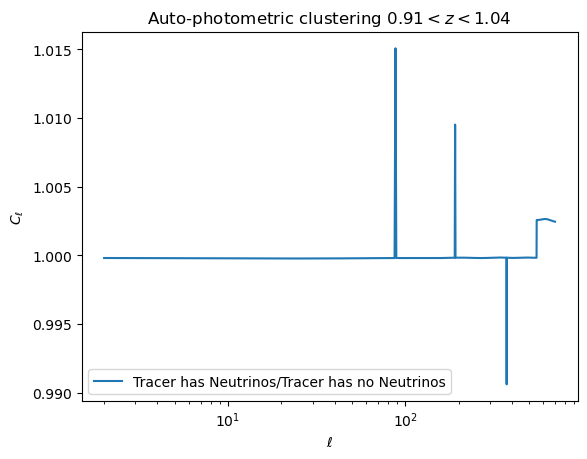

In [16]:
plt.title("Auto-photometric clustering $0.91 < z< 1.04$")
# plt.plot(ell, cls_auto_massless[4], label='All Massless Neutrinos')
plt.plot(ell, cls_tracer_neutrino[4]/cls_nu[4], label=r'Tracer has Neutrinos/Tracer has no Neutrinos')
#plt.plot(ell, , label=r'Normal Hierarchy $m_{\nu}^0 = 0.081$ eV')
# plt.plot(ell, cls_nu_m00[4], label=r'Normal Hierarchy $m_{\nu}^0$ massless')
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc=0)
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')

In [17]:
def gaussian_diag_cov(ells, Cls, noise, fsky, nbins, auto_only=True):
    fact_sky = 1./(fsky*(2*ells+1))
    cov = {k: np.zeros_like(ck) for k, ck in Cls.items()}

    if auto_only:
        for i in range(len(cov)):
            cov[i] = fact_sky*((Cls[i] + noise[i]*noise[i])**2 + (Cls[i] + noise[i]*noise[i])*(Cls[i] + noise[i]*noise[i]))
    else:
        for i in range(nbins):
            for j in range(i, nbins):
                if i == j:
                    cov[(i,j)] = fact_sky*((Cls[(i,j)] + noise[i]*noise[j])**2 + 
                                           (Cls[(i,i)] + noise[i]*noise[j])*(Cls[(j,j)] + noise[i]*noise[j]))
                else:
                    cov[(i,j)] = fact_sky*((Cls[(i,j)])**2 + (Cls[(i,i)])*(Cls[(j,j)]))
    return cov

euclid_photo_nbar = 0.3*np.ones(nbins)*(60**2)*(180/np.pi)**2 #FIXME: make sure this is correct!
euclid_sigma_e = 0.28*np.ones_like(euclid_photo_nbar)
euclid_noise_lensing = euclid_sigma_e**2/(euclid_photo_nbar*2)
euclid_noise_ph_gc = 1./euclid_photo_nbar

In [18]:
cov_ph_gc = gaussian_diag_cov(ell, cls_auto_massless, euclid_noise_ph_gc, 0.36, nbins)
cov_ph_gc_2 = gaussian_diag_cov(ell, cls_nu, euclid_noise_ph_gc, 0.36, nbins)

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))  # Create a 5x2 grid of subplots
axs = axs.ravel()  # Flatten the array of axes

fact=ell

for i, (key, value) in enumerate(cls_auto_massless.items()):  # Assuming cls is a dictionary
    #axs[i].plot(ell, value, label=f'{key}')
    axs[i].plot(ell, fact*cls_auto_massless[key], label='All Massless Neutrinos')
    axs[i].plot(ell, fact*cls_nu[key], label=r'Normal Hierarchy $m_{\nu}^0 = 0.075$ eV')
    axs[i].plot(ell, fact*cls_nu_single[key], label=r'Single massive $m_{\nu}=0.075$ ')
    axs[i].fill_between(ell, fact*(cls_auto_massless[key] + np.sqrt(cov_ph_gc[i])), 
                        fact*(cls_auto_massless[key] - np.sqrt(cov_ph_gc[i])), color='k', alpha=0.15)
    axs[i].set_xscale('log')
    axs[i].set_title(f"Auto-photometric clustering {zbins[i][0]:.2f} < z< {zbins[i][1]:.2f}")
    axs[i].set_xlabel('$\ell$')
    axs[i].set_ylabel('$\ell C_\ell$')
    axs[i].legend(loc=0)

plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()

In [19]:
average_z = np.array([np.mean(bin) for bin in zbins])

<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:15: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2175/1853103871.py:2: SyntaxWarning: invalid escape sequence '\O'
  plt.title("Euclid Auto-photometric clustering (fixed $\Omega_m=0.315$)")
/tmp/ipykernel_2175/1853103871.py:15: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$', fontsize=14)


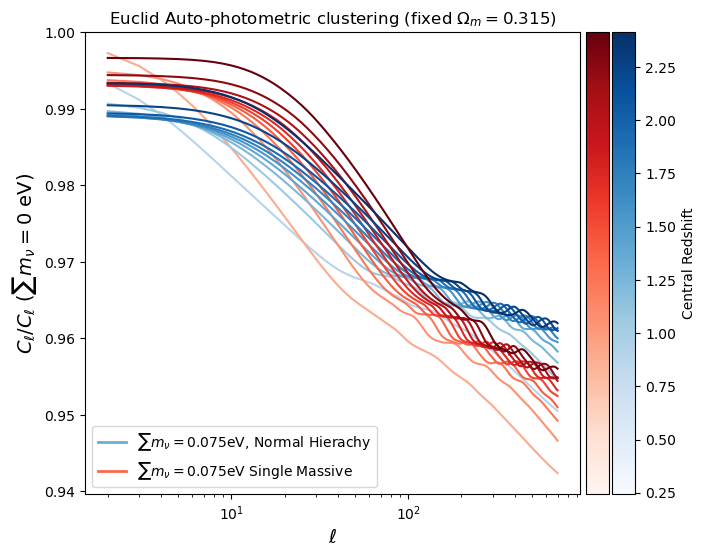

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Euclid Auto-photometric clustering (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless)))

i=0
for color, (key, value) in zip(colors, cls_auto_massless.items()):
    plt.plot(ell, cls_nu[key]/cls_auto_massless[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')
    # plt.fill_between(ell, 1-np.sqrt(cov_ph_gc_2[i]/cls_auto_massless[key]),
    #                  1+np.sqrt(cov_ph_gc_2[i]/cls_auto_massless[key]), color=colors[key])
    plt.plot(ell, cls_nu_single[key]/cls_auto_massless[key], color=colors_r[key], )#label=f'{key} but first is massless')
    i+=1
plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell/C_{\ell}$ $(\sum m_{\nu}=0$ eV)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=-0.1)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),
                Line2D([0], [0], color=cm.Reds(0.5), lw=2)]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', 
                          r'$\sum m_{\nu}=0.075 \rm{eV}$ Single Massive'], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
#plt.savefig('euclid_auto_photoclustering_singlemassless.png', dpi=300)
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:13: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2175/359825295.py:2: SyntaxWarning: invalid escape sequence '\O'
  plt.title("Euclid Auto-photometric clustering (fixed $\Omega_m=0.315$)")
/tmp/ipykernel_2175/359825295.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$', fontsize=14)


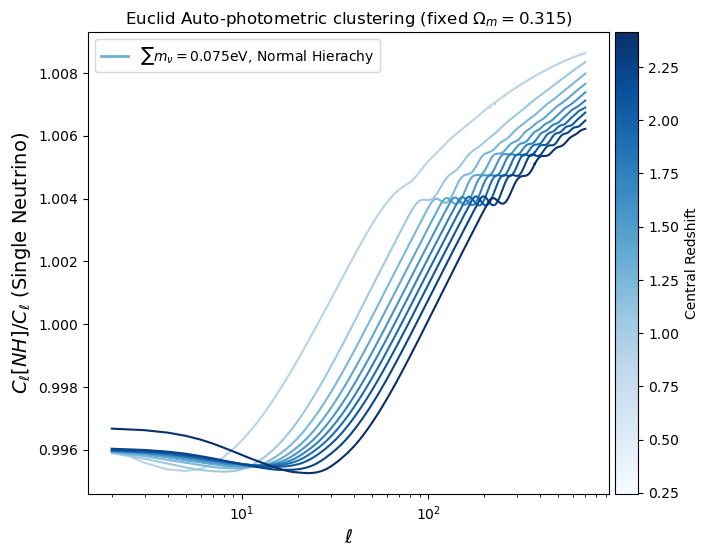

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Euclid Auto-photometric clustering (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless)))

i=0
for color, (key, value) in zip(colors, cls_auto_massless.items()):
    plt.plot(ell, cls_nu[key]/cls_nu_single[key], color=colors[key], )
    #plt.plot(ell, cls_nu_single[key]/cls_auto_massless[key], color=colors_r[key], )
    i+=1
plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell [NH]/C_{\ell}$ (Single Neutrino)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=0.01)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
#cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', ], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
#plt.savefig('euclid_auto_photoclustering_single_neutrino.png', dpi=300)
plt.show()

# Lensing now

In [23]:
ell_lensing = np.arange(2, 3000)
wl_cls_auto_massless = {(i,j): ccl.angular_cl(cosmo, lens[i], lens[j], ell_lensing, l_limber=3600) 
                        for i in range(0, len(tomo_nz)) for j in range(i, len(tomo_nz))}

In [24]:
wl_cls_nu = {(i,j): ccl.angular_cl(cosmo_neutrino, lens[i], lens[j], ell_lensing, l_limber=3600) 
             for i in range(0, len(tomo_nz)) for j in range(i, len(tomo_nz))}

In [25]:
wl_cls_nu_single = {(i,j): ccl.angular_cl(cosmo_single, lens[i], lens[j], ell_lensing, l_limber=3600) 
                for i in range(0, len(tomo_nz)) for j in range(i, len(tomo_nz))}

<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:15: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2175/4133239947.py:2: SyntaxWarning: invalid escape sequence '\O'
  plt.title("Euclid Auto Weak Lensing (fixed $\Omega_m=0.315$)")
/tmp/ipykernel_2175/4133239947.py:15: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$', fontsize=14)


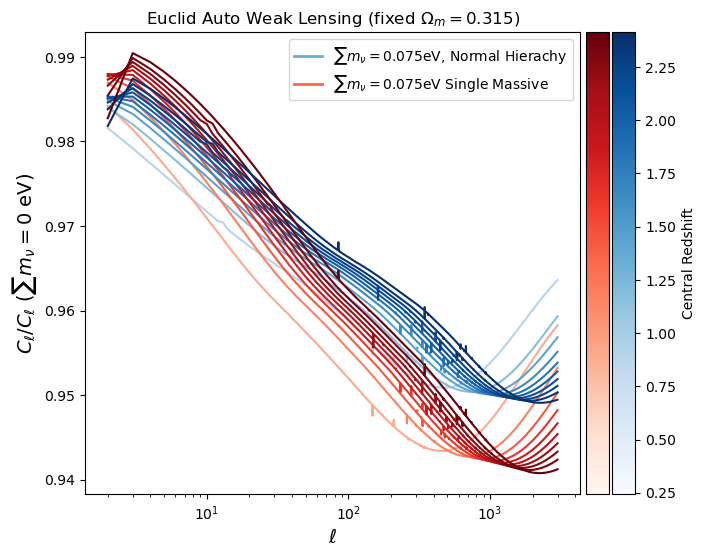

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Euclid Auto Weak Lensing (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(wl_cls_nu_single)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(wl_cls_nu_single)))

i=0
for color, (key, value) in zip(colors, wl_cls_auto_massless.items()):
    if key[0] == key[1]:
        plt.plot(ell_lensing, wl_cls_nu[key]/wl_cls_auto_massless[key], color=colors[i], )#label=f'{key} sum = 0.26 eV')
        plt.plot(ell_lensing, wl_cls_nu_single[key]/wl_cls_auto_massless[key], color=colors_r[i], )#label=f'{key} but first is massless')
    i+=1

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell/C_{\ell}$ $(\sum m_{\nu}=0$ eV)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=-0.1)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),
                Line2D([0], [0], color=cm.Reds(0.5), lw=2)]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', 
                          r'$\sum m_{\nu}=0.075 \rm{eV}$ Single Massive'], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
#plt.savefig('euclid_auto_weak_lensing_single_massless.png', dpi=300)
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:15: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2175/3790647783.py:2: SyntaxWarning: invalid escape sequence '\O'
  plt.title("Euclid Auto Weak Lensing (fixed $\Omega_m=0.315$)")
/tmp/ipykernel_2175/3790647783.py:15: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$', fontsize=14)


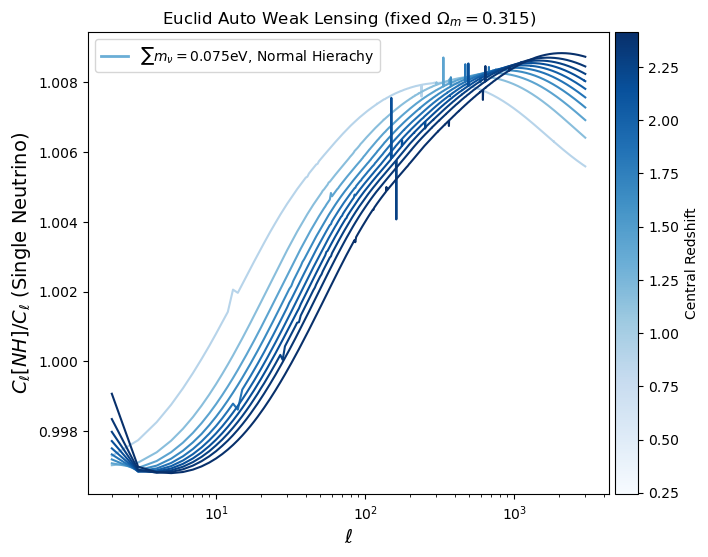

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Euclid Auto Weak Lensing (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(wl_cls_nu_single)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(wl_cls_nu_single)))

i=0
for color, (key, value) in zip(colors, wl_cls_auto_massless.items()):
    if key[0] == key[1]:
        plt.plot(ell_lensing, wl_cls_nu[key]/wl_cls_nu_single[key], color=colors[i], )#label=f'{key} sum = 0.26 eV')
        #plt.plot(ell_lensing, wl_cls_nu_single[key]/wl_cls_auto_massless[key], color=colors_r[i], )#label=f'{key} but first is massless')
    i+=1

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell [NH]/C_{\ell}$ (Single Neutrino)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=0.01)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
#cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', ], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
#plt.savefig('euclid_auto_weak_lensing_single.png', dpi=300)
plt.show()

# GGL

In [29]:
ggl_cls_auto_massless = {i: ccl.angular_cl(cosmo, clust_rsd[i], lens[i+1], ell, l_limber=620) 
                     for i in range(0, len(tomo_nz)-1)}
ggl_cls_nu = {i: ccl.angular_cl(cosmo_neutrino, clust_rsd[i], lens[i+1], ell, l_limber=620) 
                     for i in range(0, len(tomo_nz)-1)}
ggl_cls_nu_single = {i: ccl.angular_cl(cosmo_single, clust_rsd[i], lens[i+1], ell, l_limber=620) 
                     for i in range(0, len(tomo_nz)-1)}

<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:13: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2175/2622938923.py:2: SyntaxWarning: invalid escape sequence '\O'
  plt.title("Euclid GGL (fixed $\Omega_m=0.315$)")
/tmp/ipykernel_2175/2622938923.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$', fontsize=14)


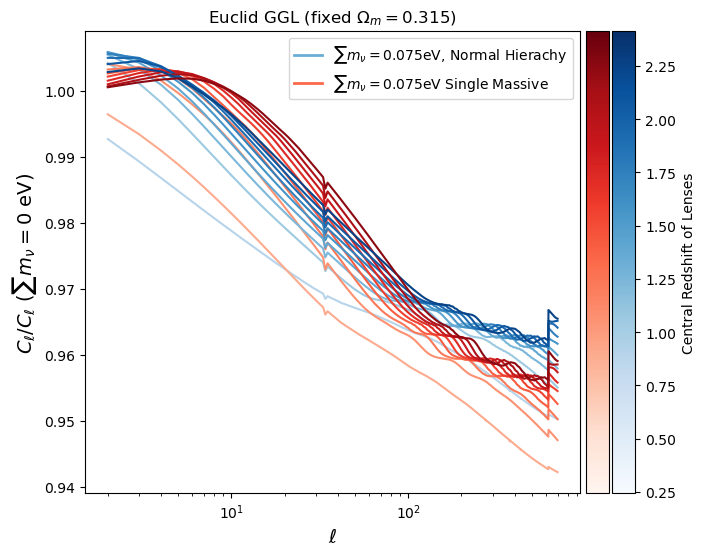

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Euclid GGL (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless)))


for color, (key, value) in zip(colors, ggl_cls_auto_massless.items()):
    plt.plot(ell, ggl_cls_nu[key]/ggl_cls_auto_massless[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')
    plt.plot(ell, ggl_cls_nu_single[key]/ggl_cls_auto_massless[key], color=colors_r[key], )#label=f'{key} but first is massless')

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell/C_{\ell}$ $(\sum m_{\nu}=0$ eV)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift of Lenses', pad=-0.1)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),
                Line2D([0], [0], color=cm.Reds(0.5), lw=2)]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', 
                          r'$\sum m_{\nu}=0.075 \rm{eV}$ Single Massive'], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
#plt.savefig('euclid_ggl_single_massless.png', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Euclid GGL (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless)))


for color, (key, value) in zip(colors, ggl_cls_auto_massless.items()):
    plt.plot(ell, ggl_cls_nu[key]/ggl_cls_nu_single[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')


plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell [NH]/C_{\ell}$ (Single Neutrino)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=0.01)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
#cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', ], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
#plt.savefig('euclid_ggl_single.png', dpi=300)
plt.show()

# Spec Euclid Clustering

In [ ]:
clust_rsd_spec = {i: ccl.NumberCountsTracer(cosmo, dndz=(z, tomo_nz_spec[i]), has_rsd=True, bias=(z,bz),) 
                  for i in range(0, len(tomo_nz_spec))}

cls_auto_massless_spec = {i: ccl.angular_cl(cosmo, clust_rsd_spec[i], clust_rsd_spec[i], ell, l_limber=1) 
                         for i in range(0, len(tomo_nz_spec))}

cls_nu_spec = {i: ccl.angular_cl(cosmo_neutrino, clust_rsd_spec[i], clust_rsd_spec[i], ell, l_limber=1) 
                for i in range(0, len(tomo_nz_spec))}

cls_nu_single = {i: ccl.angular_cl(cosmo_single, clust_rsd_spec[i], clust_rsd_spec[i], ell, l_limber=1) 
                     for i in range(0, len(tomo_nz_spec))}

In [ ]:
average_z_spec = np.array([np.mean(bin) for bin in zbins_spec])

fig, ax = plt.subplots(figsize=(6, 4))
plt.title("Euclid Auto-Spec Clustering (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless_spec)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless_spec)))


for color, (key, value) in zip(colors, cls_auto_massless_spec.items()):
    #print(key)
    if key == 19:
        print(">>>", key)
        pass
    else:
        #print(key)
        plt.plot(ell, cls_nu_spec[key]/cls_auto_massless_spec[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')
        plt.plot(ell, cls_nu_single[key]/cls_auto_massless_spec[key], color=colors_r[key], )#label=f'{key} but first is massless')

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_{\ell}/C_{\ell}$ $(\Sigma m_{\nu}=0$)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z_spec.min(), vmax=average_z_spec.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical',  pad=-0.1)
cbar.set_label('Mean Bin Redshift', size=15) 

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z_spec.min(), vmax=average_z_spec.max()))
sm_r.set_array([])
cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),
                Line2D([0], [0], color=cm.Reds(0.5), lw=2)]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', 
                          r'$\sum m_{\nu}=0.075 \rm{eV}$ Single Massive'], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
#plt.ylim(1.0, 1.)
#plt.savefig('euclid_auto_spec_clustering_single_massless.png', dpi=300)
plt.show()

In [ ]:
average_z_spec = np.array([np.mean(bin) for bin in zbins_spec])

fig, ax = plt.subplots(figsize=(6, 4))
plt.title("Euclid Auto-Spec Clustering (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless_spec)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless_spec)))


for color, (key, value) in zip(colors, cls_auto_massless_spec.items()):
    #print(key)
    if key == 19:
        print(">>>", key)
        pass
    else:
        #print(key)
        plt.plot(ell, cls_nu_spec[key]/cls_nu_single[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell [NH]/C_{\ell}$ (Single Neutrino)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=0.01)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
#cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', ], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
#plt.savefig('euclid_auto_spec_clustering_single.png', dpi=300)
plt.show()

# CMB Cross Correlations

## CMB lensing x Spec Clustering

In [ ]:
cmb_lensing_tracer = ccl.tracers.CMBLensingTracer(cosmo, z_source=1100, n_samples=5500)

cmb_lensing_tracer2 = ccl.tracers.CMBLensingTracer(cosmo_neutrino, z_source=1100, n_samples=5500)

cmb_lensing_tracer3 = ccl.tracers.CMBLensingTracer(cosmo_single, z_source=1100, n_samples=5500)

In [ ]:
specGC_x_cmbLen_masless = {i: ccl.angular_cl(cosmo, cmb_lensing_tracer, clust_rsd_spec[i], ell, l_limber=1120) 
                             for i in range(0, len(tomo_nz))}

specGC_x_cmbLen_nu = {i: ccl.angular_cl(cosmo_neutrino, cmb_lensing_tracer2, clust_rsd_spec[i], ell, l_limber=1120) 
                               for i in range(0, len(tomo_nz))}

specGC_x_cmbLen_single = {i: ccl.angular_cl(cosmo_single, cmb_lensing_tracer3, clust_rsd_spec[i], ell, l_limber=1120) 
                               for i in range(0, len(tomo_nz))}

In [ ]:
average_z_spec = np.array([np.mean(bin) for bin in zbins_spec])

fig, ax = plt.subplots(figsize=(6, 4))
plt.title("Euclid Spec Clustering x CMB Lensing (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless_spec)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless_spec)))


for color, (key, value) in zip(colors, specGC_x_cmbLen_masless.items()):
        plt.plot(ell, specGC_x_cmbLen_nu[key]/specGC_x_cmbLen_masless[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')
        plt.plot(ell, specGC_x_cmbLen_single[key]/specGC_x_cmbLen_masless[key], color=colors_r[key], )#label=f'{key} but first is massless')

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_{\ell}/C_{\ell}$ $(\Sigma m_{\nu}=0$)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z_spec.min(), vmax=average_z_spec.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical',  pad=-0.1)
cbar.set_label('Mean Bin Redshift', size=15) 

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z_spec.min(), vmax=average_z_spec.max()))
sm_r.set_array([])
cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),
                Line2D([0], [0], color=cm.Reds(0.5), lw=2)]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', 
                          r'$\sum m_{\nu}=0.075 \rm{eV}$ Single Massive'], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
plt.ylim(0.70, 1.5)
plt.xlim(8, 550)
plt.savefig('euclid_spec_clustering_x_cmb_lensing_single_massless.png', dpi=300)
plt.show()

In [ ]:
average_z_spec = np.array([np.mean(bin) for bin in zbins_spec])

fig, ax = plt.subplots(figsize=(6, 4))
plt.title("Euclid Spec Clustering x CMB Lensing (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless_spec)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless_spec)))


for color, (key, value) in zip(colors, specGC_x_cmbLen_masless.items()):
        plt.plot(ell, specGC_x_cmbLen_nu[key]/specGC_x_cmbLen_single[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')
        #plt.plot(ell, specGC_x_cmbLen_single[key]/specGC_x_cmbLen_masless[key], color=colors_r[key], )#label=f'{key} but first is massless')

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell [NH]/C_{\ell}$ (Single Neutrino)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=0.01)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
#cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', ], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
plt.ylim(0.90, 1.1)
plt.xlim(8, 950)
plt.savefig('euclid_spec_clustering_x_cmb_lensing_single.png', dpi=300)
plt.show()

# Photo GC x CMB Lensing

In [ ]:
photoGC_x_cmbLen_masless = {i: ccl.angular_cl(cosmo, cmb_lensing_tracer, clust_rsd[i], ell, l_limber=10) 
                             for i in range(0, len(tomo_nz))}

photoGC_x_cmbLen_nu = {i: ccl.angular_cl(cosmo_neutrino, cmb_lensing_tracer2, clust_rsd[i], ell, l_limber=10) 
                               for i in range(0, len(tomo_nz))}

photoGC_x_cmbLen_single = {i: ccl.angular_cl(cosmo_single, cmb_lensing_tracer3, clust_rsd[i], ell, l_limber=10) 
                               for i in range(0, len(tomo_nz))}

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Euclid Photo GC x CMB Lensing (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless)))


for color, (key, value) in zip(colors, photoGC_x_cmbLen_masless.items()):
    if key==9:
        pass
    else:
        plt.plot(ell, photoGC_x_cmbLen_nu[key]/photoGC_x_cmbLen_masless[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')
        plt.plot(ell, photoGC_x_cmbLen_single[key]/photoGC_x_cmbLen_masless[key], color=colors_r[key], )#label=f'{key} but first is massless')

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell/C_{\ell}$ $(\sum m_{\nu}=0$ eV)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=-0.1)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),
                Line2D([0], [0], color=cm.Reds(0.5), lw=2)]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', 
                          r'$\sum m_{\nu}=0.075 \rm{eV}$ Single Massive'], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
plt.xlim(0, 550)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Euclid Photo GC x CMB Lensing (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless)))


for color, (key, value) in zip(colors, photoGC_x_cmbLen_masless.items()):
    if key==9:
        pass
    else:
        plt.plot(ell, photoGC_x_cmbLen_nu[key]/photoGC_x_cmbLen_single[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell [NH]/C_{\ell}$ (Single Neutrino)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=0.01)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
#cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', ], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
#plt.ylim(0.90, 1.1)
plt.xlim(8, 950)
#plt.savefig('euclid_spec_clustering_x_cmb_lensing_single.png', dpi=300)
plt.show()

# Euclid WL x CMB Lensing

In [ ]:
wl_x_cmbLen_masless = {i: ccl.angular_cl(cosmo, cmb_lensing_tracer, lens[i], ell_lensing, l_limber=10) 
                             for i in range(0, len(tomo_nz))}

wl_x_cmbLen_nu = {i: ccl.angular_cl(cosmo_neutrino, cmb_lensing_tracer2, lens[i], ell_lensing, l_limber=10) 
                               for i in range(0, len(tomo_nz))}

wl_x_cmbLen_single = {i: ccl.angular_cl(cosmo_single, cmb_lensing_tracer3, lens[i], ell_lensing, l_limber=10) 
                               for i in range(0, len(tomo_nz))}

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Euclid Weak Lensing x CMB Lensing (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless)))


for color, (key, value) in zip(colors, wl_x_cmbLen_nu.items()):
    if key==9:
        pass
    else:
        plt.plot(ell_lensing, wl_x_cmbLen_nu[key]/wl_x_cmbLen_masless[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')
        plt.plot(ell_lensing, wl_x_cmbLen_single[key]/wl_x_cmbLen_masless[key], color=colors_r[key], )#label=f'{key} but first is massless')

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell/C_{\ell}$ $(\sum m_{\nu}=0$ eV)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=-0.1)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),
                Line2D([0], [0], color=cm.Reds(0.5), lw=2)]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', 
                          r'$\sum m_{\nu}=0.075 \rm{eV}$ Single Massive'], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
plt.xlim(4, 3000)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Euclid Weak Lensing x CMB Lensing (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless)))


for color, (key, value) in zip(colors, wl_x_cmbLen_nu.items()):
    if key==9:
        pass
    else:
        plt.plot(ell_lensing, wl_x_cmbLen_nu[key]/wl_x_cmbLen_single[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell [NH]/C_{\ell}$ (Single Neutrino)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=0.01)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
#cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', ], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
#plt.ylim(0.90, 1.1)
plt.xlim(8, 950)
#plt.savefig('euclid_spec_clustering_x_cmb_lensing_single.png', dpi=300)
plt.show()

## tSZ 

In [ ]:
tSZ_massless = ccl.tracers.tSZTracer(cosmo)
tSZ_nu = ccl.tracers.tSZTracer(cosmo_neutrino)
tSZ_single = ccl.tracers.tSZTracer(cosmo_single)

### tSZ x Spec Clustering

In [ ]:
specGC_x_tSZ_masless = {i: ccl.angular_cl(cosmo, tSZ_massless, clust_rsd_spec[i], ell, l_limber=1) 
                             for i in range(0, len(tomo_nz))}

specGC_x_tSZ_nu = {i: ccl.angular_cl(cosmo_neutrino, tSZ_nu, clust_rsd_spec[i], ell, l_limber=1) 
                               for i in range(0, len(tomo_nz))}

specGC_x_tSZ_single = {i: ccl.angular_cl(cosmo_single, tSZ_single, clust_rsd_spec[i], ell, l_limber=1) 
                               for i in range(0, len(tomo_nz))}

In [ ]:
average_z_spec = np.array([np.mean(bin) for bin in zbins_spec])

fig, ax = plt.subplots(figsize=(6, 4))
plt.title("Euclid Spec Clustering x tSZ (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless_spec)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless_spec)))


for color, (key, value) in zip(colors, specGC_x_tSZ_masless.items()):
        plt.plot(ell, specGC_x_tSZ_nu[key]/specGC_x_tSZ_masless[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')
        plt.plot(ell, specGC_x_tSZ_single[key]/specGC_x_tSZ_masless[key], color=colors_r[key], )#label=f'{key} but first is massless')

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_{\ell}/C_{\ell}$ $(\Sigma m_{\nu}=0$)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z_spec.min(), vmax=average_z_spec.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical',  pad=-0.1)
cbar.set_label('Mean Bin Redshift', size=15) 

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z_spec.min(), vmax=average_z_spec.max()))
sm_r.set_array([])
cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),
                Line2D([0], [0], color=cm.Reds(0.5), lw=2)]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', 
                          r'$\sum m_{\nu}=0.075 \rm{eV}$ Single Massive'], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
#plt.ylim(0.80, 1.2)
plt.xlim(8, 550)
plt.show()

In [ ]:
average_z_spec = np.array([np.mean(bin) for bin in zbins_spec])

fig, ax = plt.subplots(figsize=(6, 4))
plt.title("Euclid Spec Clustering x tSZ (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless_spec)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless_spec)))


for color, (key, value) in zip(colors, specGC_x_tSZ_masless.items()):
        plt.plot(ell, specGC_x_tSZ_nu[key]/specGC_x_tSZ_single[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')


plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell [NH]/C_{\ell}$ (Single Neutrino)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=0.01)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
#cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', ], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
plt.ylim(0.99, 1.01)
plt.xlim(8, 950)
#plt.savefig('euclid_spec_clustering_x_cmb_lensing_single.png', dpi=300)
plt.show()

## tSZ x Weak Lensing

In [ ]:
wl_x_tSZ_masless = {i: ccl.angular_cl(cosmo, tSZ_massless, lens[i], ell_lensing, l_limber=1) 
                             for i in range(0, len(tomo_nz))}

wl_x_tSZ_nu = {i: ccl.angular_cl(cosmo_neutrino, tSZ_nu, lens[i], ell_lensing, l_limber=1) 
                               for i in range(0, len(tomo_nz))}

wl_x_tSZ_single = {i: ccl.angular_cl(cosmo_single, tSZ_single, lens[i], ell_lensing, l_limber=1) 
                               for i in range(0, len(tomo_nz))}

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Euclid Weak Lensing x CMB Lensing (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless)))


for color, (key, value) in zip(colors, wl_x_tSZ_masless.items()):
    if key==9:
        pass
    else:
        plt.plot(ell_lensing, wl_x_tSZ_nu[key]/wl_x_tSZ_masless[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')
        plt.plot(ell_lensing, wl_x_tSZ_single[key]/wl_x_tSZ_masless[key], color=colors_r[key], )#label=f'{key} but first is massless')

plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell/C_{\ell}$ $(\sum m_{\nu}=0$ eV)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=-0.1)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),
                Line2D([0], [0], color=cm.Reds(0.5), lw=2)]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', 
                          r'$\sum m_{\nu}=0.075 \rm{eV}$ Single Massive'], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
plt.xlim(4, 4500)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Euclid Weak Lensing x CMB Lensing (fixed $\Omega_m=0.315$)")
colors = cm.Blues(np.linspace(0.3, 1, len(cls_auto_massless)))
colors_r = cm.Reds(np.linspace(0.3, 1, len(cls_auto_massless)))


for color, (key, value) in zip(colors, wl_x_tSZ_masless.items()):
    if key==9:
        pass
    else:
        plt.plot(ell_lensing, wl_x_tSZ_nu[key]/wl_x_tSZ_single[key], color=colors[key], )#label=f'{key} sum = 0.26 eV')


plt.xscale('log')
#plt.legend(loc=0)
plt.xlabel('$\ell$', fontsize=14)
plt.ylabel(r'$C_\ell [NH]/C_{\ell}$ (Single Neutrino)', fontsize=14)

# Create a ScalarMappable object for each colormap
sm = mpl.cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Central Redshift', pad=0.01)

sm_r = mpl.cm.ScalarMappable(cmap=cm.Reds, norm=plt.Normalize(vmin=average_z.min(), vmax=average_z.max()))
sm_r.set_array([])
#cbar_r = plt.colorbar(sm_r, ax=ax, orientation='vertical', pad=0.01)

# Remove ticks and labels from the Reds colorbar
cbar_r.ax.yaxis.set_ticks([])
#cbar_r.ax.yaxis.set_label_position('none')
# Create custom legend
custom_lines = [Line2D([0], [0], color=cm.Blues(0.5), lw=2),]
plt.legend(custom_lines, [r'$\sum m_{\nu}=0.075 \rm{eV}$, Normal Hierachy', ], loc=0)

# Move the labels and ticks to the right in the Blues colorbar
cbar.ax.yaxis.tick_right()
cbar.ax.yaxis.set_label_position('right')
plt.ylim(1.0, 1.01)
plt.xlim(8, ell_lensing.max())
#plt.savefig('euclid_spec_clustering_x_cmb_lensing_single.png', dpi=300)
plt.show()